# Voxel-to-voxel correlation maps
### This notebook is used to perform correlation-based parcellation

## <font color=009DD2> <span style="background-color: #A9C4C0"> Imports

In [38]:
import sys,json
import glob, os
import numpy as np
sys.path.append('/media/miplab-nas2/Data3/BMPD/hc_project/analysis/code/')

from seed_to_voxels import Seed2voxels
from fc_based_parcellation import FC_Parcellation

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <font color=009DD2> <span style="background-color: #A9C4C0"> Initialization

### <font color=009DD2> I Configuration & parameters </font>

In [52]:
with open('../config/config_NK.json') as config_file:
    config = json.load(config_file) # load config file

# Parameters (maybe we should move them to config?)
signal='raw'
seed_names=['C6'] # Define seed names
seed_structure='spinalcord' # Define structure in which seeds are defined (brain or spinal cord)
target_structure='brain' # Define structure to use as target (brain or spinal cord)
ktot = 9
seed_folder = '/spinalcord_icas_k' + str(ktot) + '/' # Name of folder containing seed tcs, etc.

### <font color=009DD2> II Select files </font>

In [67]:
# /!\ Important notes: 
# Different from ai-based correlation analyses, no _ai suffix appended here for the timeseries txt files

# One target per subject
# We use the unsmoothed data in template space (smoothing can be applied during time courses extraction if needed)
data_target=[];ts_target_txt=[]
for subject_name in config['list_subjects']:
    data_target.append(config['coreg_dir'] + '/sub-' + subject_name + '/' + target_structure + '/sub-' + subject_name + '_task-rest_bold_stc_' + target_structure + config['coreg_tag'][target_structure] + '.nii.gz')
    ts_target_txt.append(config['main_dir'] + config['seed2vox_dir'] + '/' + target_structure +'_all/timeseries/sub-' + subject_name + '_' + target_structure + '_all_timeseries')
mask_target=config['main_dir'] + config['masks'][target_structure]

# Create directories if needed
if not os.path.exists(config['main_dir'] + config['seed2vox_dir'] + '/' + target_structure + '_all/timeseries/'):
    os.mkdir(config['main_dir'] + config['seed2vox_dir'] + '/' + target_structure + '_all')
    os.mkdir(config['main_dir'] + config['seed2vox_dir'] + '/' + target_structure + '_all/timeseries/') # folder to store timeseries extraction
    
# But possible to have multiple seeds (so create a dictionary to store list of each seed)
data_seed={}; ts_seed_txt={}; mask_seed={}
for seed_name in seed_names:
    data_seed[seed_name] = []
    ts_seed_txt[seed_name] = []
    
    # Create directory for seed if it doesn't exist
    if not os.path.exists(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name):
        os.mkdir(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name)

    # For ICA-based seeds
    # We take the binarized ICs (here, matched to individual spinal elvels)
    mask_seed[seed_name] = glob.glob(config['main_dir'] + config['data']['ica']['spinalcord_dir'] + 'k_' + str(ktot) + '/' + 'comp_bin/' + config['data']['ica']['tag_filename'] + '*' + seed_name + '*.gz')[0]
    for subject_name in config['list_subjects']:
        data_seed[seed_name].append(config['coreg_dir'] + 'sub-'+ subject_name + '/' + seed_structure + '/sub-' + subject_name + '_task-rest_bold_stc_sc_' + config['coreg_tag'][seed_structure] + '.nii.gz')
        
        # Here, spinal cord is going to be smoothed, hence the tag _s3x3x6 to avoid confusion
        ts_seed_txt[seed_name].append(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name+'/timeseries/sub-' + subject_name + '_' + seed_name + '_timeseries_s3x3x6')
    
    # Create folder for timeseries
    if not os.path.exists(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name + '/timeseries/'):
        os.mkdir(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name + '/timeseries/')
    
    # Create folder for connectivity-based parcellation
    if not os.path.exists(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name + '/cbp/'):
        os.mkdir(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name + '/cbp/')



### <font color=009DD2> III Initialize class based on this </font>

In [68]:
seed2voxels=Seed2voxels(config,signal,seed_names,target_name) # initialize the function

## <font color=009DD2> <span style="background-color: #A9C4C0"> Data extraction


### <font color=009DD2> I. Time series extraction - Seed </font>

In [61]:
# Dictionary with seed names
# Contains one array per subject

# !! Here, smooth seed with 3x3x6 kernel

seed_timeseries={};seed_timeseries_mean={};seed_timeseries_pc1={};
for seed_name in seed_names:
    seed_timeseries[seed_name]=[]
    seed_timeseries_mean[seed_name]=[]
    seed_timeseries_pc1[seed_name]=[]
    (seed_timeseries[seed_name],seed_timeseries_mean[seed_name],seed_timeseries_pc1[seed_name])=seed2voxels.extract_data(img=data_seed[seed_name], smoothing_fwhm=[3,3,6], mask=mask_seed[seed_name],timeseries_txt=ts_seed_txt[seed_name],run="extract",n_jobs=8) # Load or extract timecourses in seed

### <font color=009DD2> II. Time series extraction - Target </font>

In [69]:
(target_timeseries,target_timeseries_mean,target_timeseries_pc1)=seed2voxels.extract_data(img=data_target, smoothing_fwhm=[6,6,6], mask=mask_target, timeseries_txt=ts_target_txt,
                run="load",n_jobs=8) # Load voxelwise brain signals as target

## <font color=009DD2> <span style="background-color: #A9C4C0"> Correlation analysis voxelwise

In [ ]:
import numpy as np
from joblib import Parallel, delayed

output_img={};
for seed_name in seed_names: # For each seed
    output_img[seed_name]=[]
    seed = np.array(seed_timeseries[seed_name])
    # Compute in parallel for all voxels
    output_img[seed_name] = Parallel(n_jobs=8)(delayed(seed2voxels.correlation_maps)(seed[:,:,voxel],target_timeseries,mask=mask_target,output_img=None,Fisher=True,save_maps=False,n_jobs=8)
                                               for voxel in range(seed.shape[2]))
    # Save seed results as .npy
    np.save(config['main_dir'] + config['seed2vox_dir'] + seed_folder + seed_name + 'cbp' + '/allsub_' + seed_name + '_voxels2' + target_structure + 'brain+sc_smoothed',np.array(output_img[seed_name]))
               

In [14]:
import numpy as np

output_img={};
for seed_name in seed_names: # For each seed
    output_img[seed_name]=[]
    seed = np.array(seed_timeseries[seed_name])
    # Loop through voxels
    for voxel in range(seed.shape[2]):
        seed_voxel = seed[:,:,voxel]
        output_img[seed_name].append(seed2voxels.correlation_maps(seed_voxel,target_timeseries,mask=mask_target,output_img=None,Fisher=True,save_maps=False,n_jobs=8))
    # Save seed results as .npy
    np.save(config['main_dir'] + config['seed2vox_dir'] + '/spinalcord_icas_k' + str(ktot) +'/C3/' +target_name[0]+'_fc_maps/allsub_C3_voxels2brain_brain+sc_smoothed',np.array(output_img[seed_name]))


## <font color=009DD2> <span style="background-color: #A9C4C0"> FC-based parcellation

### <font color=009DD2> Method 1: https://www.jneurosci.org/content/32/18/6240 </font>
<font color=009DD2> **Since this method is based on averaging maps from a single voxel in spine, use smoothing in brain + spine** </font>

In [5]:
# To load data
connectivity = np.load(config['main_dir'] + config['seed2vox_dir'] + '/spinalcord_icas_k' + str(ktot) +'/C3/' +target_name[0]+'_fc_maps/allsub_C3_voxels2brain_brain+sc_smoothed.npy')

In [13]:
# Alternatively, to use those just extracted
# connectivity = np.array(output_img[seed_name])

NameError: name 'output_img' is not defined

In [6]:
# Take the mean over subjects
mean_connectivity = np.squeeze(np.mean(connectivity,axis=1))

In [7]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
# Question: do we need to scale the input data? I'd say no, as we are comparing voxel correlations and not different types of features with different scales

In [33]:
clustering = KMeans(n_clusters=4,init='k-means++',n_init=10,max_iter=100)
clustering.fit(mean_connectivity)

KMeans(max_iter=100, n_clusters=4)

In [37]:
clustering.labels_[:300]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2], d

In [10]:
kmeans_kwargs = {
     "init": "k-means++",
     "n_init": 100,
     "max_iter": 300,
     }

In [32]:

sse = []
silhouette_coefficients = []


for k in range(2,10):
    kmeans = KMeans(n_clusters=k,**kmeans_kwargs)
    kmeans.fit(mean_connectivity)
    sse.append(kmeans.inertia_)
    score = silhouette_score(mean_connectivity, kmeans.labels_)
    silhouette_coefficients.append(score)

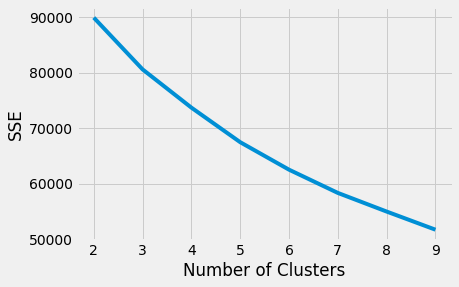

In [33]:
plt.plot(range(2, 10), sse)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [34]:
kl = KneeLocator(
    range(2, 10), sse, curve="convex", direction="decreasing"
)

kl.elbow

5

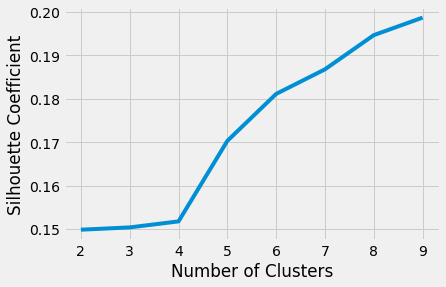

In [36]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 10), silhouette_coefficients)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [11]:
# For K = 5
kmeans = KMeans(n_clusters=5,**kmeans_kwargs)
kmeans.fit(mean_connectivity)

KMeans(n_clusters=5, n_init=100)

In [44]:
import nibabel as nib
seed_img = nib.load(mask_seed['C3'])
seed_data = seed_img.get_fdata()
labels_data = seed_data
labels_data[np.where(labels_data==1)] = kmeans.labels_+1
labels_img = nib.Nifti1Image(labels_data, seed_img.affine)
nib.save(labels_img, config['main_dir'] + config['seed2vox_dir'] + '/spinalcord_icas_k' + str(ktot) +'/C3/labels_k5.nii.gz')

In [24]:
brain_maps = np.zeros((len(np.unique(kmeans.labels_)), mean_connectivity.shape[1]))
for label in np.unique(kmeans.labels_):
    brain_maps[label,:] = np.mean(mean_connectivity[np.where(kmeans.labels_==label),:],axis=1)

In [69]:
target_img = nib.load(mask_target)
target_data = target_img.get_fdata()
for label in np.unique(kmeans.labels_):
    clust_data = seed_data
    labels_data[np.where(labels_data==1)] = kmeans.labels_+1
    labels_img = nib.Nifti1Image(labels_data, seed_img.affine)
    nib.save(labels_img, config['main_dir'] + config['seed2vox_dir'] + '/spinalcord_icas_k' + str(ktot) +'/C3/brain_pattern_k_' num2str(label+1) '.nii.gz')

(5, 44238)

In [25]:
from nilearn.maskers import NiftiMasker
from nilearn import image
masker= NiftiMasker(mask_target).fit()
for label in np.unique(kmeans.labels_):
    img = masker.inverse_transform(brain_maps[label,:])
    img.to_filename(config['main_dir'] + config['seed2vox_dir'] + '/spinalcord_icas_k' + str(ktot) +'/C3/brain_pattern_k_' + str(label+1) + '.nii.gz')

In [18]:
brain_maps[label,:]

array([0.03234403, 0.03234403, 0.03234403, ..., 0.03234403, 0.03234403,
       0.03234403])